# Traffic Sign Classification

build a model for classifying traffic signs

## Dataset

The dataset we’ll be using to train our own custom traffic sign classifier is the German Traffic Sign Benchmark https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed

### About the dataset

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

#### Credits

* [https://benchmark.ini.rub.de/](https://benchmark.ini.rub.de/)

In [1]:
!python3 --version

Python 3.7.12


In [2]:
import os
import zipfile
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, AvgPool2D, BatchNormalization, Reshape

from sklearn.model_selection import train_test_split
import tqdm
import shutil

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

Download the dataset from source

In [3]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip

--2021-12-12 11:17:08--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 65.9.84.91, 65.9.84.144, 65.9.84.166, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|65.9.84.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  31.3MB/s    in 4.3s    

2021-12-12 11:17:13 (27.6 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]



In [4]:
!ls

sample_data  traffic-signs-data.zip


In [5]:
!du -sh traffic-signs-data.zip

118M	traffic-signs-data.zip


Load labels

In [6]:
!wget https://gist.githubusercontent.com/ceccode/119e37bcc2320819b7445c1090c0fe06/raw/0e3801a7c09091d9b9200ac454a4ba99203652c8/labels.csv

--2021-12-12 11:17:14--  https://gist.githubusercontent.com/ceccode/119e37bcc2320819b7445c1090c0fe06/raw/0e3801a7c09091d9b9200ac454a4ba99203652c8/labels.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]     999  --.-KB/s    in 0s      

2021-12-12 11:17:14 (50.4 MB/s) - ‘labels.csv’ saved [999/999]



In [7]:
!ls

labels.csv  sample_data  traffic-signs-data.zip


## Data preparation and data clearning

Extract the dataset

In [8]:
zip_ref = zipfile.ZipFile("./traffic-signs-data.zip", 'r')
zip_ref.extractall("../tmp/traffic-signs")
zip_ref.close()

In [9]:
BASE_PATH = '../tmp/traffic-signs/'

In [10]:
shutil.copyfile('./labels.csv', BASE_PATH + 'labels_name.csv') 

shutil.copyfile('./labels.csv', BASE_PATH + 'labels_train.csv')
shutil.copyfile('./labels.csv', BASE_PATH + 'labels_valid.csv')
shutil.copyfile('./labels.csv', BASE_PATH + 'labels_test.csv')

'../tmp/traffic-signs/labels_test.csv'

In [11]:
label_df = pd.read_csv(BASE_PATH + 'labels_name.csv')
label_df

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [12]:
import pickle
from PIL import Image

In [13]:
# load the database
training_file =  BASE_PATH + "train.p"
validation_file= BASE_PATH + "valid.p"
testing_file =   BASE_PATH + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [14]:
os.makedirs(BASE_PATH + 'train', exist_ok=True)
os.makedirs(BASE_PATH + 'valid', exist_ok=True)
os.makedirs(BASE_PATH + 'test', exist_ok=True)

Move image file in test / train / valid

In [15]:
train['features']

array([[[[ 28,  25,  24],
         [ 27,  24,  23],
         [ 27,  24,  22],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  25],
         [ 31,  27,  26]],

        [[ 29,  26,  25],
         [ 27,  25,  23],
         [ 27,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        [[ 28,  26,  26],
         [ 27,  25,  23],
         [ 26,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        ...,

        [[ 27,  24,  23],
         [ 28,  25,  24],
         [ 30,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 29,  25,  22]],

        [[ 28,  23,  23],
         [ 29,  24,  24],
         [ 31,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 28,  24,  21]],

        [[ 29,  23,  23],
         [ 30,  24,  24],
         [ 32,  24,  23],
         ...,
         [ 27,  24,  22],
        

In [16]:
train['labels']

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

Write images and labels

In [17]:
with open(BASE_PATH+'labels_train.csv', 'w') as labels:
    # -- TRAINING --
    counter = 0
    for f,l in zip(train['features'], train['labels']):
        # write f to a jpg
        relname = "train/{name}.png".format(name=counter)
        fname = "{root}".format(root=BASE_PATH) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1

with open(BASE_PATH+'labels_valid.csv', 'w') as labels:   
    counter = 0 
    for f,l in zip(valid['features'], valid['labels']):
        # write f to a jpg
        relname = "valid/{name}.png".format(name=counter)
        fname = "{root}".format(root=BASE_PATH) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1

with open(BASE_PATH+'labels_test.csv', 'w') as labels:    
    counter = 0      
    # -- TEST --
    for f,l in zip(test['features'], test['labels']):
        # write f to a jpg
        relname = "test/{name}.png".format(name=counter)
        fname = "{root}".format(root=BASE_PATH) + relname
        im = Image.fromarray(f)
        im.save(fname)
        # write l to labels.csv
        labels.write("{file},{label}\n".format(file=relname, label=l))
        counter += 1



Show some images

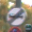

In [18]:
name_1 = 'train/100.png'
image_fullname = f'{BASE_PATH}{name_1}'
load_img(image_fullname)

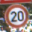

In [19]:
name_2 = 'train/10040.png'
image_fullname = f'{BASE_PATH}{name_2}'
load_img(image_fullname)

In [20]:
img = load_img(image_fullname)
x = np.array(img)
x.shape

(32, 32, 3)

Train and Valid dataset

In [21]:
df_train = pd.read_csv(BASE_PATH + 'labels_train.csv', names=["path", "class"])
df_train.head()

,path,class
0,train/0.png,41
1,train/1.png,41
2,train/2.png,41
3,train/3.png,41
4,train/4.png,41


In [22]:
df_train.isnull().sum()

path     0
class    0
dtype: int64

In [23]:
df_train["class"].value_counts()

2     2010
1     1980
13    1920
12    1890
38    1860
10    1800
4     1770
5     1650
25    1350
9     1320
7     1290
8     1260
3     1260
11    1170
18    1080
35    1080
17     990
31     690
14     690
33     599
15     540
26     540
28     480
23     450
30     390
34     360
6      360
16     360
22     330
36     330
40     300
20     300
21     270
39     270
24     240
29     240
32     210
42     210
41     210
27     210
37     180
19     180
0      180
Name: class, dtype: int64

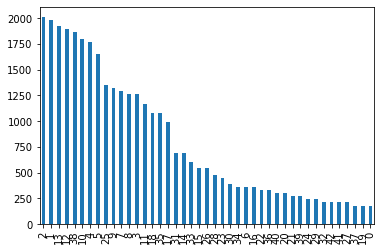

In [24]:
df_train['class'].value_counts().plot(kind='bar')
plt.show()  # density=False would make counts

The top class (Speed limit 50km) has over 3000 examples while the least represented class ("roundabout mandatory" end "End of no passing") has under 300 examples.

In [25]:
df_valid = pd.read_csv(BASE_PATH + 'labels_valid.csv', names=["path", "class"])
df_valid.head()

,path,class
0,valid/0.png,41
1,valid/1.png,41
2,valid/2.png,41
3,valid/3.png,41
4,valid/4.png,41


In [26]:
train_dir = os.path.join(BASE_PATH, 'train')
valid_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

Train folder has 43 different folders named from 0 to 42. Each folder contains images from the respective class.

In [27]:
for i in range(43):
  os.makedirs(train_dir + "/" +  str(i), exist_ok=True)
  os.makedirs(valid_dir + "/" +  str(i), exist_ok=True)

In [28]:
for i in range(len(df_train)) :
  source = BASE_PATH + df_train.loc[i, 'path']
  destination = train_dir + '/' + str(df_train.loc[i, 'class'])
  if (os.path.exists(source)):
    shutil.move(source, destination)



In [29]:
for i in range(len(df_valid)) :
  source = BASE_PATH + df_valid.loc[i, 'path']
  destination = valid_dir + '/' + str(df_valid.loc[i, 'class'])
  if (os.path.exists(source)):
    shutil.move(source, destination)

## Model Creation

In [30]:
NUM_CLASSES = 43

DENSE_LAYER_ACTIVATION = 'softmax'
LOSS_METRICS = ['accuracy']

LEARNING_RATE = 0.001

NUM_EPOCHS = 10

STEPS_PER_EPOCH_TRAINING = 100
STEPS_PER_EPOCH_VALIDATION = 50

BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 50

In [31]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation=DENSE_LAYER_ACTIVATION))

Optimizer

In [32]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [33]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 128)               921728    
                                                                 
 dense_1 (Dense)             (None, 43)                5547      
                                                                 
Total params: 928,171
Trainable params: 928,171
Non-trainable params: 0
__________________________________________________

### Generators and Training

In [35]:
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=BATCH_SIZE_TRAINING,
    shuffle=True
)

Found 34799 images belonging to 43 classes.


In [36]:
train_ds.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '5': 38,
 '6': 39,
 '7': 40,
 '8': 41,
 '9': 42}

In [37]:
val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    valid_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=BATCH_SIZE_VALIDATION,
    shuffle=True
)

Found 4410 images belonging to 43 classes.


In [38]:
val_ds.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '5': 38,
 '6': 39,
 '7': 40,
 '8': 41,
 '9': 42}

In [39]:
history = model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING, # images = batch_size * steps
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    validation_steps=STEPS_PER_EPOCH_VALIDATION # images = batch_size * steps
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


100/100 [==============================] - 8s 73ms/step - loss: 2.5859 - accuracy: 0.3733 - val_loss: 1.9890 - val_accuracy: 0.4688
Epoch 2/10
100/100 [==============================] - 7s 71ms/step - loss: 1.3052 - accuracy: 0.6555 - val_loss: 1.3299 - val_accuracy: 0.6616
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.7969 - accuracy: 0.7996 - val_loss: 0.9525 - val_accuracy: 0.7608
Epoch 4/10
100/100 [==============================] - 7s 71ms/step - loss: 0.5311 - accuracy: 0.8738 - val_loss: 0.8498 - val_accuracy: 0.7788
Epoch 5/10
100/100 [==============================] - 7s 70ms/step - loss: 0.4017 - accuracy: 0.9086 - val_loss: 0.7163 - val_accuracy: 0.8076
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.3134 - accuracy: 0.9342 - val_loss: 0.6650 - val_accuracy: 0.8336
Epoch 7/10
100/100 [==============================] - 7s 70ms/step - loss: 0.2619 - accuracy: 0.9427 - val_loss: 0.6889 - val_accuracy: 0.8496
Epoch 8/10

###Model metrics

In [40]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [41]:
acc = history.history['accuracy'] #training acc
val_acc = history.history['val_accuracy'] #validation acc
loss = history.history['loss']
val_loss = history.history['val_loss']

Accurancy median

In [42]:
acc_median = np.median(acc)
acc_median

0.9213999807834625

Loss std

In [43]:
loss_std = np.std(loss)
loss_std

0.7188787880646275

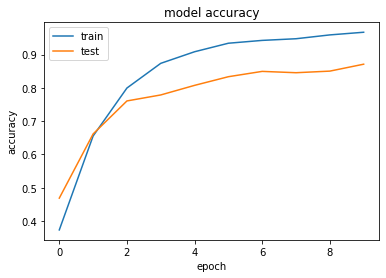

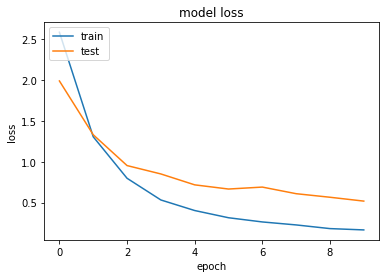

In [44]:
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Data augmentation

Training a model with augmentations

In [45]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

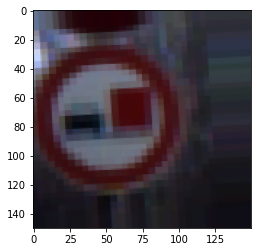

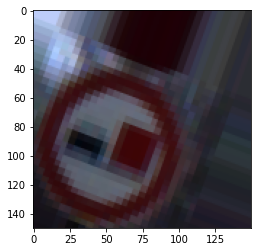

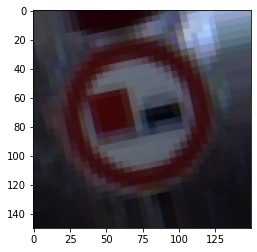

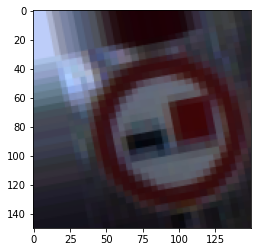

In [46]:
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_dir+"/10", fname) for
    fname in os.listdir(train_dir+"/10")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(32, 32), 
                                                    class_mode="categorical",
                                                    batch_size=BATCH_SIZE_TRAINING)


Found 34799 images belonging to 43 classes.


In [50]:
validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(32, 32),
    class_mode="categorical",
    batch_size=BATCH_SIZE_VALIDATION)

Found 4410 images belonging to 43 classes.


## Model fitting (augmented) and Accuracy/Loss Evaluation

In [51]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION)

Epoch 1/10
100/100 [==============================] - 10s 102ms/step - loss: 3.1433 - accuracy: 0.2011 - val_loss: 1.8402 - val_accuracy: 0.4844
Epoch 2/10
100/100 [==============================] - 10s 102ms/step - loss: 2.4699 - accuracy: 0.2842 - val_loss: 1.7281 - val_accuracy: 0.5040
Epoch 3/10
100/100 [==============================] - 10s 102ms/step - loss: 2.2947 - accuracy: 0.3336 - val_loss: 1.6555 - val_accuracy: 0.5316
Epoch 4/10
100/100 [==============================] - 10s 102ms/step - loss: 2.1741 - accuracy: 0.3639 - val_loss: 1.5909 - val_accuracy: 0.5380
Epoch 5/10
100/100 [==============================] - 10s 102ms/step - loss: 2.0698 - accuracy: 0.3886 - val_loss: 1.5962 - val_accuracy: 0.5640
Epoch 6/10
100/100 [==============================] - 10s 102ms/step - loss: 2.0034 - accuracy: 0.4002 - val_loss: 1.5952 - val_accuracy: 0.5768
Epoch 7/10
100/100 [==============================] - 10s 104ms/step - loss: 1.9083 - accuracy: 0.4235 - val_loss: 1.6203 - val_ac

### Model metrics

In [52]:
acc = history.history['accuracy'] #training acc
val_acc = history.history['val_accuracy'] #validation acc
loss = history.history['loss']
val_loss = history.history['val_loss']

Accurancy median

In [53]:
acc_median = np.median(acc)
acc_median

0.3944000005722046

Loss std

In [54]:
loss_std = np.std(loss)
loss_std

0.39047111511530785

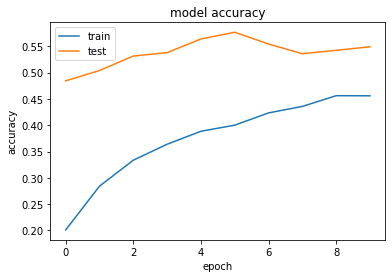

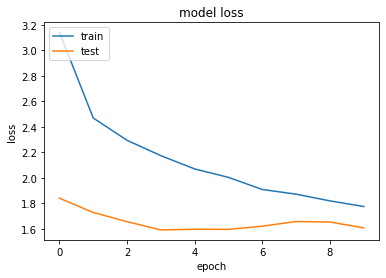

In [55]:
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Export model

In [56]:
MODEL_PATH = BASE_PATH + 'traffic-sign-model.h5'

tf.keras.models.save_model(
    model,
    MODEL_PATH,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)



# Load Model and Evaluate

In [57]:
model_loaded = keras.models.load_model(MODEL_PATH)

In [58]:
test_gen = ImageDataGenerator(rescale=1./255)

test_ds = test_gen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    shuffle=False
)

model_loaded.evaluate(test_ds)

Found 34799 images belonging to 43 classes.
   5/1088 [..............................] - ETA: 13s - loss: 1.1741 - accuracy: 0.5437 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1088/1088 [==============================] - 13s 12ms/step - loss: 0.9302 - accuracy: 0.7312


[0.9302126169204712, 0.7312279343605042]

# Predict

In [59]:
path = test_dir + '/100.png' #Speed limit (30km/h)
img = load_img(path, target_size=(32, 32))

import numpy as np
x = np.array(img)
X = np.array([x])


In [60]:
X.shape

(1, 32, 32, 3)

In [61]:
def preprocess_input(x):
    return x / 255.0

X = preprocess_input(X)

In [62]:
pred = model_loaded.predict(X)

In [63]:
pred

array([[1.23786621e-01, 7.24362850e-01, 1.30724895e-03, 8.83054803e-04,
        8.61106020e-10, 4.31739318e-05, 1.19258942e-07, 3.04809801e-04,
        1.33544812e-02, 5.46156453e-09, 1.10157323e-03, 2.00905488e-04,
        7.82638341e-02, 1.68939849e-07, 1.51061482e-04, 6.25376051e-05,
        1.95830478e-04, 1.19722250e-03, 1.14946230e-03, 1.52397183e-06,
        3.42424755e-04, 1.17450167e-04, 2.96297163e-04, 3.60933039e-03,
        8.22916991e-06, 1.88684899e-05, 1.00537065e-07, 5.53594415e-09,
        2.85197643e-09, 5.34247047e-09, 1.11703802e-08, 4.76411029e-11,
        1.67264016e-08, 1.22644825e-10, 6.37341710e-03, 2.32386466e-09,
        8.66151595e-08, 4.44796981e-08, 5.61283669e-03, 4.84006002e-10,
        2.41764632e-04, 5.83870897e-05, 3.69541310e-02]], dtype=float32)

In [64]:
classes = [
  "Speed limit (20km/h)",
  "Speed limit (30km/h)",
  "Speed limit (50km/h)",
  "Speed limit (60km/h)",
  "Speed limit (70km/h)",
  "Speed limit (80km/h)",
  "End of speed limit (80km/h)",
  "Speed limit (100km/h)",
  "Speed limit (120km/h)",
  "No passing",
  "No passing for vehicles over 3.5 metric tons",
  "Right-of-way at the next intersection",
  "Priority road",
  "Yield",
  "Stop",
  "No vehicles",
  "Vehicles over 3.5 metric tons prohibited",
  "No entry",
  "General caution",
  "Dangerous curve to the left",
  "Dangerous curve to the right",
  "Double curve",
  "Bumpy road",
  "Slippery road",
  "Road narrows on the right",
  "Road work",
  "Traffic signals",
  "Pedestrians",
  "Children crossing",
  "Bicycles crossing",
  "Beware of ice/snow",
  "Wild animals crossing",
  "End of all speed and passing limits",
  "Turn right ahead",
  "Turn left ahead",
  "Ahead only",
  "Go straight or right",
  "Go straight or left",
  "Keep right",
  "Keep left",
  "Roundabout mandatory",
  "End of no passing",
  "End of no passing by vehicles over 3.5 metric tons"
]
dict(zip(classes, pred[0]))

{'Ahead only': 2.3238647e-09,
 'Beware of ice/snow': 1.117038e-08,
 'Bicycles crossing': 5.3424705e-09,
 'Bumpy road': 0.00029629716,
 'Children crossing': 2.8519764e-09,
 'Dangerous curve to the left': 1.5239718e-06,
 'Dangerous curve to the right': 0.00034242476,
 'Double curve': 0.00011745017,
 'End of all speed and passing limits': 1.6726402e-08,
 'End of no passing': 5.838709e-05,
 'End of no passing by vehicles over 3.5 metric tons': 0.03695413,
 'End of speed limit (80km/h)': 1.1925894e-07,
 'General caution': 0.0011494623,
 'Go straight or left': 4.4479698e-08,
 'Go straight or right': 8.661516e-08,
 'Keep left': 4.84006e-10,
 'Keep right': 0.0056128367,
 'No entry': 0.0011972225,
 'No passing': 5.4615645e-09,
 'No passing for vehicles over 3.5 metric tons': 0.0011015732,
 'No vehicles': 6.2537605e-05,
 'Pedestrians': 5.535944e-09,
 'Priority road': 0.078263834,
 'Right-of-way at the next intersection': 0.00020090549,
 'Road narrows on the right': 8.22917e-06,
 'Road work': 1.8

Speed limit (30km/h)

# Convert the model for use with TensorFlow lite

In [65]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
tflite_model = converter.convert()

# Save the model.
MODEL_TFLITE_PATH = BASE_PATH + 'traffic-sign-model.tflite'

with open(MODEL_TFLITE_PATH, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy7_9cm5e/assets


Predict with TS Lite

In [66]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 14.8 MB/s 


In [67]:
import tensorflow.lite as tflite
import tflite_runtime.interpreter as tflite

import os
import numpy as np

from io import BytesIO
from urllib import request

from PIL import Image


MODEL_NAME = MODEL_TFLITE_PATH


def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img


def prepare_input(x):
    return x / 255.0


interpreter = tflite.Interpreter(model_path=MODEL_NAME)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']


def predict(url):
    img = download_image(url)
    img = prepare_image(img, target_size=(32, 32))

    x = np.array(img, dtype='float32')
    X = np.array([x])
    X = prepare_input(X)

    interpreter.set_tensor(input_index, X)
    interpreter.invoke()

    preds = interpreter.get_tensor(output_index)

    return preds

In [68]:
url = 'http://clipart-library.com/images/gieERjykT.jpg'
preds = predict(url)
dict(zip(classes, pred[0]))

{'Ahead only': 2.3238647e-09,
 'Beware of ice/snow': 1.117038e-08,
 'Bicycles crossing': 5.3424705e-09,
 'Bumpy road': 0.00029629716,
 'Children crossing': 2.8519764e-09,
 'Dangerous curve to the left': 1.5239718e-06,
 'Dangerous curve to the right': 0.00034242476,
 'Double curve': 0.00011745017,
 'End of all speed and passing limits': 1.6726402e-08,
 'End of no passing': 5.838709e-05,
 'End of no passing by vehicles over 3.5 metric tons': 0.03695413,
 'End of speed limit (80km/h)': 1.1925894e-07,
 'General caution': 0.0011494623,
 'Go straight or left': 4.4479698e-08,
 'Go straight or right': 8.661516e-08,
 'Keep left': 4.84006e-10,
 'Keep right': 0.0056128367,
 'No entry': 0.0011972225,
 'No passing': 5.4615645e-09,
 'No passing for vehicles over 3.5 metric tons': 0.0011015732,
 'No vehicles': 6.2537605e-05,
 'Pedestrians': 5.535944e-09,
 'Priority road': 0.078263834,
 'Right-of-way at the next intersection': 0.00020090549,
 'Road narrows on the right': 8.22917e-06,
 'Road work': 1.8